In [1]:
import sys
sys.path.append("..")

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from datasets.backdoor_dataset import CIFAR10M,CustomDataset_224,CIFAR10Mem
import numpy as np
from datasets.bd_dataset_imagenet_filter import BadEncoderDataset
from torch import nn
torch.cuda.set_device(1)

def dataloader(dataset):
    batch_size=512
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(1, 1, 1, 0.5)], p=1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
        ])

    clean_transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
                ])

    memory_data = CIFAR10M(numpy_file=f'../data/{dataset}/train.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    train_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_data = CIFAR10M(numpy_file=f'../data/{dataset}/test.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_loader,test_loader

def dataloader_stl10(dataset):
    batch_size=512
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(1, 1, 1, 0.5)], p=1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.44087798, 0.42790666, 0.38678814], [0.25507198, 0.24801506, 0.25641308])
        ])

    clean_transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.44087798, 0.42790666, 0.38678814], [0.25507198, 0.24801506, 0.25641308])
                ])

    memory_data = CIFAR10M(numpy_file=f'../data/{dataset}/train.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    train_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_data = CIFAR10M(numpy_file=f'../data/{dataset}/test.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_loader,test_loader

In [5]:
import torch.nn.functional as F
import os,random,copy
import kornia.augmentation as A

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle

class ProbTransform(torch.nn.Module):
    def __init__(self, f, p=1):
        super(ProbTransform, self).__init__()
        self.f = f
        self.p = p

    def forward(self, x):  # , **kwargs):
        if random.random() < self.p:
            return self.f(x)
        else:
            return x


class PostTensorTransform(torch.nn.Module):
    def __init__(self):
        super(PostTensorTransform, self).__init__()
        self.random_crop = ProbTransform(
            A.RandomCrop((32, 32), padding=5), p=0.8
        )
        self.random_rotation = ProbTransform(A.RandomRotation(10), p=0.5)


    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x


def wanet(clean_img):
    input_height=32
    grid_rescale=1
    s=0.5
    k=4
    num_bd = clean_img.shape[0] // 2
    num_cross = num_bd
    ins = torch.rand(1, 2, k, k) * 2 - 1
    ins = ins / torch.mean(torch.abs(ins))
    noise_grid = (
        F.upsample(ins, size=input_height, mode="bicubic", align_corners=True)
        .permute(0, 2, 3, 1)
        .cuda()
    )
    array1d = torch.linspace(-1, 1, steps=input_height)
    x, y = torch.meshgrid(array1d, array1d)
    identity_grid = torch.stack((y, x), 2)[None, ...].cuda()

    grid_temps = (identity_grid + s * noise_grid / input_height) * grid_rescale
    grid_temps = torch.clamp(grid_temps, -1, 1)
    transforms = PostTensorTransform().cuda()

    ins = torch.rand(num_cross, input_height, input_height, 2).cuda() * 2 - 1
    grid_temps2 = grid_temps.repeat(num_cross, 1, 1, 1) + ins / input_height
    grid_temps2 = torch.clamp(grid_temps2, -1, 1)

    inputs_bd = F.grid_sample(clean_img[:num_bd], grid_temps.repeat(num_bd, 1, 1, 1), align_corners=True)

    inputs_cross = F.grid_sample(clean_img[num_bd : (num_bd + num_cross)], grid_temps2, align_corners=True)

    total_inputs = torch.cat([inputs_bd, inputs_cross], dim=0)
    backdoored_img = transforms(total_inputs)
    return backdoored_img





# # 加载预训练的ResNet50模型并修改最后一层以适应二分类任务
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)  # 二分类
# model = model.cuda()  # 确保模型在CUDA设备上

# 定义损失函数（虽然在测试中可能不需要，除非你想计算损失）
# criterion = nn.CrossEntropyLoss()


# def train_and_test_model(model, train_loader, test_loader):
#     # 训练模式
#     # 定义损失函数和优化器
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     epochs=1

#     model.train()
#     for epoch in range(epochs):  # 多个周期
#         train_loss = 0.0
#         for clean_img, aug_img in tqdm(train_loader):
#             clean_img = clean_img.cuda()
#             aug_img = aug_img.cuda()
#             # 使用wanet处理clean_img
#             wanet_bd = wanet(clean_img)

#             # 准备输入数据和标签
#             inputs = torch.cat([wanet_bd, aug_img], dim=0)
#             labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             # 清零梯度
#             optimizer.zero_grad()

#             # 前向传播，反向传播，优化
#             outputs = model(inputs)
#             # print(outputs.shape)
#             loss = criterion(outputs[1], labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * inputs.size(0)

#         print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}')

#     # 测试模式
#     model.eval()
#     correct = 0
#     total = 0
#     test_loss = 0.0
#     y_true = []
#     y_pred = []
#     y_score = []

#     with torch.no_grad():
#         for clean_img, aug_img in tqdm(test_loader):
#             clean_img = clean_img.cuda()
#             aug_img = aug_img.cuda()
#             wanet_bd = wanet(clean_img)

#             inputs = torch.cat([wanet_bd, aug_img], dim=0)
#             labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             outputs = model(inputs)
#             loss = criterion(outputs[1], labels)
#             test_loss += loss.item() * inputs.size(0)

#             _, predicted = torch.max(outputs[1], 1)
#             probs = torch.nn.functional.softmax(outputs[1], dim=1)[:, 1]

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(predicted.cpu().numpy())
#             y_score.extend(probs.cpu().numpy())

#     avg_loss = test_loss / total
#     accuracy = 100 * correct / total
#     f1 = f1_score(y_true, y_pred)
#     auroc = roc_auc_score(y_true, y_score)

#     print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}, AUROC: {auroc:.4f}')



def train_and_test_model_tsne(args, model, train_loader, test_loader):
    # 省略训练部分的代码...
    # model.fc = nn.Identity()  # 移除最后一层
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs=50
    clean_model = deepcopy(model)
    clean_model = clean_model.f
    clean_model.eval()
    label_to_str = {0: 'WaNet', 1: 'Augment'}

    bd_model = model.f
    bd_model.train()
    for epoch in range(epochs):  # 多个周期
        train_loss = 0.0
        for clean_img, aug_img in tqdm(train_loader):
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            # 使用wanet处理clean_img
            wanet_bd = wanet(clean_img)

            # 准备输入数据和标签
            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 清零梯度
            optimizer.zero_grad()
            # print(inputs.shape)

            # 前向传播，反向传播，优化
            outputs = bd_model(inputs)
            # print(outputs)
            loss1 = criterion(outputs, labels)

            feature_clean = clean_model(clean_img)
            feature_clean = F.normalize(feature_clean, dim=-1)
            features_bd = bd_model(wanet_bd)
            feature_bd = F.normalize(features_bd, dim=-1)
            loss2 = - torch.sum(feature_clean * feature_bd, dim=-1).mean()
            # print(loss1, loss2)
            loss = 0.005*loss1 + loss2


            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}, L1:{loss1.item():.4f} ,L2: {loss2.item():.4f}')

    # 测试模式
    bd_model.eval()
    features_list = []
    labels_list = []
    # model.g.classifier = nn.Identity()  # 移除最后一层

    with torch.no_grad():
        for i,(clean_img, aug_img) in enumerate(tqdm(test_loader)):
            if i > 5:
                break
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            wanet_bd = wanet(clean_img)

            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 使用模型的特征提取方法
            features = bd_model(inputs)
            # print(features[0].shape)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            # 其余的测试代码，计算损失，准确率等...

    # 将features和labels_tsne转换为适合t-SNE的格式
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # 可视化
    plt.figure(figsize=(10, 6))
    plt.xticks([])
    plt.yticks([])
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=[label_to_str[label.item()] for label in labels],
        palette = sns.color_palette(["#0c84c6", "#41b7ac"]),
        legend="full",
        alpha=0.8
    )
    plt.savefig(f'{args.encoder_usage_info}.pdf')
    # plt.title('t-SNE visualization of model features')
    plt.show()

# 注意：此代码假设wanet函数和其他必要的模块已经定义并可以正常工作



def train_and_test_model_tsne_adaptive(args, model, train_loader, test_loader):
    # 省略训练部分的代码...
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 30
    clean_model = deepcopy(model)
    clean_model = clean_model.f
    clean_model.eval()
    label_to_str = {0: 'WaNet', 1: 'Augment'}
    loss1_all = []
    bd_model = model.f
    bd_model.train()
    # 初始化loss2的权重
    weight_loss2 = 1.0
    for epoch in range(epochs):  # 多个周期
        train_loss = 0.0
        loss1_sum = 0.0  # 用于计算平均loss1
        loss2_sum = 0.0  # 用于计算平均loss2
        total_samples = 0
        for clean_img, aug_img in tqdm(train_loader):
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            # 使用wanet处理clean_img
            wanet_bd = wanet(clean_img)

            # 准备输入数据和标签
            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 清零梯度
            optimizer.zero_grad()

            # 前向传播，反向传播，优化
            outputs = bd_model(inputs)
            loss1 = criterion(outputs, labels)

            feature_clean = clean_model(clean_img)
            feature_clean = F.normalize(feature_clean, dim=-1)
            features_bd = bd_model(clean_img)
            feature_bd = F.normalize(features_bd, dim=-1)
            loss2 = - torch.sum(feature_clean * feature_bd, dim=-1).mean()

            loss2_sum += loss2.item() * clean_img.size(0)
            loss1_sum += loss1.item() * clean_img.size(0)

            total_samples += clean_img.size(0)

            loss = 0.05 * loss1/loss1.item() + weight_loss2 * loss2

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # 计算平均loss2并据此调整权重
        avg_loss2 = loss2_sum / total_samples
        avg_loss1 = loss1_sum / total_samples
        loss1_all.append(avg_loss1)

        # if avg_loss2 > -0.97:
        #     weight_loss2 *= 1.1  # 增大权重
        # else:
        #     weight_loss2 *= 0.95  # 减小权重

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}, avg_loss1:{avg_loss1:.4f}, Avg L2: {avg_loss2:.4f}, Weight L2: {weight_loss2:.4f}')

    # 测试模式
    bd_model.eval()
    features_list = []
    labels_list = []
    # model.g.classifier = nn.Identity()  # 移除最后一层
    print(loss1_all)

    with torch.no_grad():
        for i,(clean_img, aug_img) in enumerate(tqdm(test_loader)):
            if i > 5:
                break
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            wanet_bd = wanet(clean_img)

            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 使用模型的特征提取方法
            features = bd_model(inputs)
            # print(features[0].shape)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            # 其余的测试代码，计算损失，准确率等...

    # 将features和labels_tsne转换为适合t-SNE的格式
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # 可视化
    plt.figure(figsize=(7, 4))
    plt.xticks([])
    plt.yticks([])
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=[label_to_str[label.item()] for label in labels],
        palette = sns.color_palette(["#0c84c6", "#41b7ac"]),
        legend="full",
        alpha=0.8
    )
    res = {'tsne': tsne_results, 'labels': labels, 'loss1': loss1_all}
    pickle.dump(res, open(f'insight/{args.encoder_usage_info}_res.pkl', 'wb'))
    plt.savefig(f'{args.encoder_usage_info}.pdf')
    # plt.title('t-SNE visualization of model features')
    plt.show()

# 注意：此代码假设wanet函数和其他必要的模块已经定义并可以正常工作

In [15]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/cifar10/clean_encoder/model_1000.pth',
    encoder_usage_info='cifar10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader('cifar10')
# train_and_test_model(clean_model, train_loader, test_loader)
train_and_test_model_tsne_adaptive(args, clean_model, train_loader, test_loader)

  0%|          | 0/98 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Epoch 1, Train Loss: -1.7589, L1:5.9128, Avg L2: -0.9295, Weight L2: 1.1000


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Epoch 2, Train Loss: -1.9812, L1:5.6126, Avg L2: -0.9460, Weight L2: 1.2100


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 3, Train Loss: -2.1948, L1:4.9592, Avg L2: -0.9483, Weight L2: 1.3310


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Epoch 4, Train Loss: -2.4268, L1:4.0178, Avg L2: -0.9492, Weight L2: 1.4641


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch 5, Train Loss: -2.6836, L1:3.0229, Avg L2: -0.9506, Weight L2: 1.6105


100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Epoch 6, Train Loss: -2.9638, L1:2.2374, Avg L2: -0.9512, Weight L2: 1.7716


100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Epoch 7, Train Loss: -3.2736, L1:1.6702, Avg L2: -0.9522, Weight L2: 1.9487


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 8, Train Loss: -3.6066, L1:1.1345, Avg L2: -0.9510, Weight L2: 2.1436


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 9, Train Loss: -3.9812, L1:0.7371, Avg L2: -0.9520, Weight L2: 2.3579


100%|██████████| 98/98 [00:41<00:00,  2.38it/s]


Epoch 10, Train Loss: -4.3905, L1:0.4558, Avg L2: -0.9522, Weight L2: 2.5937


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch 11, Train Loss: -4.8351, L1:0.3348, Avg L2: -0.9513, Weight L2: 2.8531


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch 12, Train Loss: -5.3218, L1:0.2166, Avg L2: -0.9501, Weight L2: 3.1384


100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Epoch 13, Train Loss: -5.8659, L1:0.0963, Avg L2: -0.9505, Weight L2: 3.4523


100%|██████████| 98/98 [00:42<00:00,  2.29it/s]


Epoch 14, Train Loss: -6.4532, L1:0.0649, Avg L2: -0.9491, Weight L2: 3.7975


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 15, Train Loss: -7.1202, L1:0.0363, Avg L2: -0.9506, Weight L2: 4.1772


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch 16, Train Loss: -7.8468, L1:0.0259, Avg L2: -0.9512, Weight L2: 4.5950


100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Epoch 17, Train Loss: -8.6498, L1:0.0179, Avg L2: -0.9521, Weight L2: 5.0545


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 18, Train Loss: -9.5211, L1:0.0175, Avg L2: -0.9517, Weight L2: 5.5599


100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Epoch 19, Train Loss: -10.5073, L1:0.0217, Avg L2: -0.9539, Weight L2: 6.1159


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 20, Train Loss: -11.5693, L1:0.0079, Avg L2: -0.9540, Weight L2: 6.7275


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Epoch 21, Train Loss: -12.7561, L1:0.0279, Avg L2: -0.9555, Weight L2: 7.4002


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 22, Train Loss: -14.0509, L1:0.0062, Avg L2: -0.9561, Weight L2: 8.1403


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 23, Train Loss: -15.4864, L1:0.0067, Avg L2: -0.9574, Weight L2: 8.9543


100%|██████████| 98/98 [00:42<00:00,  2.30it/s]


Epoch 24, Train Loss: -17.0552, L1:0.0035, Avg L2: -0.9579, Weight L2: 9.8497


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 25, Train Loss: -18.7686, L1:0.0028, Avg L2: -0.9578, Weight L2: 10.8347


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 26, Train Loss: -20.6688, L1:0.0203, Avg L2: -0.9584, Weight L2: 11.9182


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 27, Train Loss: -22.7683, L1:0.0023, Avg L2: -0.9594, Weight L2: 13.1100


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 28, Train Loss: -25.0530, L1:0.0111, Avg L2: -0.9593, Weight L2: 14.4210


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 29, Train Loss: -27.5722, L1:0.0015, Avg L2: -0.9594, Weight L2: 15.8631


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 30, Train Loss: -30.3790, L1:0.0204, Avg L2: -0.9607, Weight L2: 17.4494


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 31, Train Loss: -33.4135, L1:0.0011, Avg L2: -0.9603, Weight L2: 19.1943


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 32, Train Loss: -36.7800, L1:0.0016, Avg L2: -0.9607, Weight L2: 21.1138


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 33, Train Loss: -40.5169, L1:0.0008, Avg L2: -0.9619, Weight L2: 23.2252


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 34, Train Loss: -44.5709, L1:0.0132, Avg L2: -0.9617, Weight L2: 25.5477


100%|██████████| 98/98 [00:42<00:00,  2.29it/s]


Epoch 35, Train Loss: -49.0078, L1:0.0006, Avg L2: -0.9611, Weight L2: 28.1024


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Epoch 36, Train Loss: -54.0103, L1:0.0149, Avg L2: -0.9627, Weight L2: 30.9127


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 37, Train Loss: -59.4004, L1:0.0007, Avg L2: -0.9624, Weight L2: 34.0039


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 38, Train Loss: -65.3288, L1:0.0061, Avg L2: -0.9621, Weight L2: 37.4043


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 39, Train Loss: -71.9016, L1:0.0103, Avg L2: -0.9625, Weight L2: 41.1448


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 40, Train Loss: -79.1864, L1:0.0003, Avg L2: -0.9635, Weight L2: 45.2593


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch 41, Train Loss: -87.0838, L1:0.0003, Avg L2: -0.9632, Weight L2: 49.7852


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 42, Train Loss: -95.7424, L1:0.0002, Avg L2: -0.9626, Weight L2: 54.7637


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 43, Train Loss: -105.4549, L1:0.0009, Avg L2: -0.9637, Weight L2: 60.2401


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 98/98 [02:10<00:00,  1.33s/it] 


Epoch 1, Train Loss: -0.6991


100%|██████████| 98/98 [00:41<00:00,  2.39it/s]


Epoch 2, Train Loss: -0.8680


 30%|███       | 6/20 [00:02<00:06,  2.26it/s]


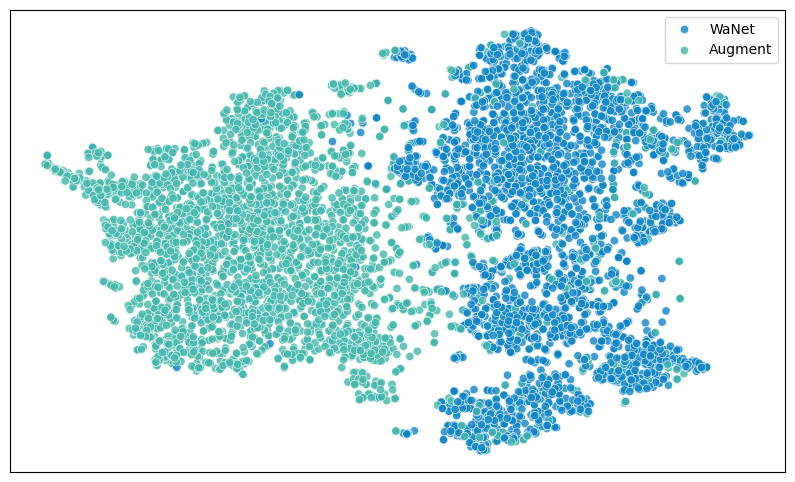

In [6]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/cifar10/clean_encoder/model_1000.pth',
    encoder_usage_info='cifar10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader('cifar10')
# train_and_test_model(clean_model, train_loader, test_loader)
train_and_test_model_tsne(args, clean_model, train_loader, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 1, Train Loss: -1.6889, avg_loss1:6.2169, Avg L2: -0.8945, Weight L2: 1.1000
[6.216913241577148]


 38%|███▊      | 6/16 [00:02<00:04,  2.16it/s]


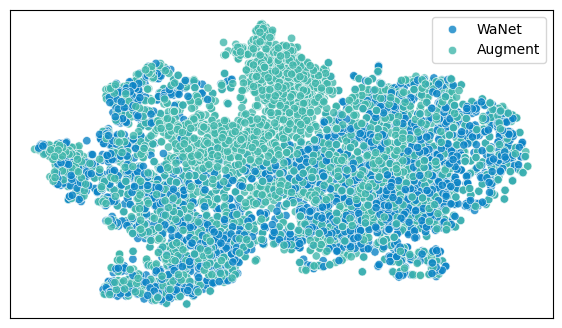

In [40]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/stl10/clean_encoder/model_1000.pth',
    encoder_usage_info='stl10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
# clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader_stl10('stl10')
train_and_test_model_tsne_adaptive(args,clean_model, train_loader, test_loader)

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 1, Train Loss: -1.7716, avg_loss1:6.2159, Avg L2: -0.9358, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 2, Train Loss: -1.8381, avg_loss1:6.1973, Avg L2: -0.9691, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 3, Train Loss: -1.8589, avg_loss1:6.1707, Avg L2: -0.9795, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 4, Train Loss: -1.8698, avg_loss1:6.1509, Avg L2: -0.9849, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 5, Train Loss: -1.8759, avg_loss1:6.1306, Avg L2: -0.9880, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 6, Train Loss: -1.8794, avg_loss1:6.1090, Avg L2: -0.9897, Weight L2: 1.0000


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 7, Train Loss: -1.8815, avg_loss1:6.0780, Avg L2: -0.9908, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 8, Train Loss: -1.8835, avg_loss1:6.0598, Avg L2: -0.9918, Weight L2: 1.0000


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 9, Train Loss: -1.8843, avg_loss1:6.0139, Avg L2: -0.9921, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 10, Train Loss: -1.8856, avg_loss1:5.9789, Avg L2: -0.9928, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 11, Train Loss: -1.8862, avg_loss1:5.9473, Avg L2: -0.9931, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 12, Train Loss: -1.8870, avg_loss1:5.8962, Avg L2: -0.9935, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 13, Train Loss: -1.8871, avg_loss1:5.8290, Avg L2: -0.9935, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 14, Train Loss: -1.8874, avg_loss1:5.7544, Avg L2: -0.9937, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 15, Train Loss: -1.8880, avg_loss1:5.6778, Avg L2: -0.9940, Weight L2: 1.0000


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 16, Train Loss: -1.8883, avg_loss1:5.5988, Avg L2: -0.9941, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 17, Train Loss: -1.8883, avg_loss1:5.5098, Avg L2: -0.9942, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 18, Train Loss: -1.8890, avg_loss1:5.4229, Avg L2: -0.9945, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 19, Train Loss: -1.8885, avg_loss1:5.3331, Avg L2: -0.9942, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 20, Train Loss: -1.8886, avg_loss1:5.2348, Avg L2: -0.9943, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 21, Train Loss: -1.8886, avg_loss1:5.1351, Avg L2: -0.9943, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch 22, Train Loss: -1.8885, avg_loss1:5.0467, Avg L2: -0.9943, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 23, Train Loss: -1.8890, avg_loss1:4.9430, Avg L2: -0.9945, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 24, Train Loss: -1.8894, avg_loss1:4.8652, Avg L2: -0.9947, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 25, Train Loss: -1.8899, avg_loss1:4.7683, Avg L2: -0.9950, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 26, Train Loss: -1.8895, avg_loss1:4.6842, Avg L2: -0.9947, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 27, Train Loss: -1.8896, avg_loss1:4.5962, Avg L2: -0.9948, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 28, Train Loss: -1.8902, avg_loss1:4.5091, Avg L2: -0.9951, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 29, Train Loss: -1.8904, avg_loss1:4.4342, Avg L2: -0.9952, Weight L2: 1.0000


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 30, Train Loss: -1.8900, avg_loss1:4.3529, Avg L2: -0.9950, Weight L2: 1.0000
[6.215869580078125, 6.1972920547485355, 6.17074531173706, 6.150854675292969, 6.130564902496338, 6.109037294769287, 6.078038762664795, 6.059817678833007, 6.013850843048096, 5.978903405761719, 5.947298865509033, 5.896223983764648, 5.829038346099853, 5.754361031341553, 5.677806071472168, 5.598760300445557, 5.50980306930542, 5.42289171295166, 5.333070848083496, 5.234781747436523, 5.135070124816894, 5.046690720367431, 4.942982917022705, 4.8652153495788575, 4.768297282409668, 4.684208539581299, 4.59618585281372, 4.509115933990478, 4.434225901031494, 4.352863352203369]


 38%|███▊      | 6/16 [00:02<00:04,  2.05it/s]


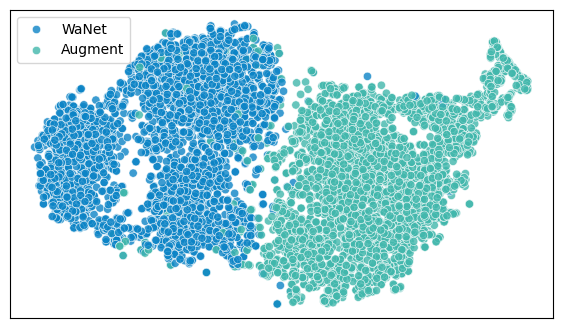

In [6]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/stl10/clean_encoder/model_1000.pth',
    encoder_usage_info='stl10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
# clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne_adaptive(args, clean_model, train_loader, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 1, Train Loss: -1.6283, avg_loss1:6.2160, Avg L2: -0.8642, Weight L2: 1.1000


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Epoch 2, Train Loss: -1.9183, avg_loss1:6.1915, Avg L2: -0.9174, Weight L2: 1.2100


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 3, Train Loss: -2.1494, avg_loss1:6.1696, Avg L2: -0.9295, Weight L2: 1.3310


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 4, Train Loss: -2.4034, avg_loss1:6.1596, Avg L2: -0.9404, Weight L2: 1.4641


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 5, Train Loss: -2.6564, avg_loss1:6.1505, Avg L2: -0.9413, Weight L2: 1.6105


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 6, Train Loss: -2.9579, avg_loss1:6.1472, Avg L2: -0.9494, Weight L2: 1.7716


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 7, Train Loss: -3.2628, avg_loss1:6.1399, Avg L2: -0.9491, Weight L2: 1.9487


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 8, Train Loss: -3.6008, avg_loss1:6.1374, Avg L2: -0.9496, Weight L2: 2.1436


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 9, Train Loss: -3.9754, avg_loss1:6.1250, Avg L2: -0.9506, Weight L2: 2.3579


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 10, Train Loss: -4.3883, avg_loss1:6.1212, Avg L2: -0.9517, Weight L2: 2.5937


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 11, Train Loss: -4.8484, avg_loss1:6.1202, Avg L2: -0.9539, Weight L2: 2.8531


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Epoch 12, Train Loss: -5.3686, avg_loss1:6.1093, Avg L2: -0.9584, Weight L2: 3.1384


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 13, Train Loss: -5.8998, avg_loss1:6.1078, Avg L2: -0.9559, Weight L2: 3.4523


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 14, Train Loss: -6.5069, avg_loss1:6.1088, Avg L2: -0.9569, Weight L2: 3.7975


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 15, Train Loss: -7.2097, avg_loss1:6.1058, Avg L2: -0.9624, Weight L2: 4.1772


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 16, Train Loss: -7.9015, avg_loss1:6.1019, Avg L2: -0.9578, Weight L2: 4.5950


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Epoch 17, Train Loss: -8.7453, avg_loss1:6.1026, Avg L2: -0.9625, Weight L2: 5.0545


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 18, Train Loss: -9.6109, avg_loss1:6.0956, Avg L2: -0.9606, Weight L2: 5.5599


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 19, Train Loss: -10.6069, avg_loss1:6.0952, Avg L2: -0.9629, Weight L2: 6.1159


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 20, Train Loss: -11.6784, avg_loss1:6.1031, Avg L2: -0.9629, Weight L2: 6.7275


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Epoch 21, Train Loss: -12.9043, avg_loss1:6.0991, Avg L2: -0.9665, Weight L2: 7.4002


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 22, Train Loss: -14.1833, avg_loss1:6.1059, Avg L2: -0.9651, Weight L2: 8.1403


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 23, Train Loss: -15.5820, avg_loss1:6.0923, Avg L2: -0.9632, Weight L2: 8.9543


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 24, Train Loss: -17.2023, avg_loss1:6.1051, Avg L2: -0.9661, Weight L2: 9.8497


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 25, Train Loss: -18.9495, avg_loss1:6.1073, Avg L2: -0.9670, Weight L2: 10.8347


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 26, Train Loss: -20.8318, avg_loss1:6.1042, Avg L2: -0.9660, Weight L2: 11.9182


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 27, Train Loss: -22.8813, avg_loss1:6.1047, Avg L2: -0.9641, Weight L2: 13.1100


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 28, Train Loss: -25.2277, avg_loss1:6.1054, Avg L2: -0.9660, Weight L2: 14.4210


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 29, Train Loss: -27.8259, avg_loss1:6.1115, Avg L2: -0.9682, Weight L2: 15.8631


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 30, Train Loss: -30.6427, avg_loss1:6.1165, Avg L2: -0.9690, Weight L2: 17.4494


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 31, Train Loss: -33.7034, avg_loss1:6.1110, Avg L2: -0.9686, Weight L2: 19.1943


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 32, Train Loss: -37.0764, avg_loss1:6.1223, Avg L2: -0.9684, Weight L2: 21.1138


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Epoch 33, Train Loss: -40.8908, avg_loss1:6.1232, Avg L2: -0.9707, Weight L2: 23.2252


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 34, Train Loss: -44.8876, avg_loss1:6.1216, Avg L2: -0.9685, Weight L2: 25.5477


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 35, Train Loss: -49.5037, avg_loss1:6.1249, Avg L2: -0.9708, Weight L2: 28.1024


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 36, Train Loss: -54.4024, avg_loss1:6.1306, Avg L2: -0.9697, Weight L2: 30.9127


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 37, Train Loss: -59.8761, avg_loss1:6.1295, Avg L2: -0.9701, Weight L2: 34.0039


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 38, Train Loss: -65.9877, avg_loss1:6.1381, Avg L2: -0.9718, Weight L2: 37.4043


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 39, Train Loss: -72.5650, avg_loss1:6.1350, Avg L2: -0.9713, Weight L2: 41.1448


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 40, Train Loss: -79.9093, avg_loss1:6.1410, Avg L2: -0.9723, Weight L2: 45.2593


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 41, Train Loss: -87.9041, avg_loss1:6.1369, Avg L2: -0.9722, Weight L2: 49.7852


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 42, Train Loss: -96.6681, avg_loss1:6.1466, Avg L2: -0.9719, Weight L2: 54.7637


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 43, Train Loss: -106.3300, avg_loss1:6.1412, Avg L2: -0.9717, Weight L2: 60.2401


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 44, Train Loss: -117.0831, avg_loss1:6.1513, Avg L2: -0.9726, Weight L2: 66.2641


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 45, Train Loss: -129.0242, avg_loss1:6.1566, Avg L2: -0.9743, Weight L2: 72.8905


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 46, Train Loss: -141.7469, avg_loss1:6.1530, Avg L2: -0.9730, Weight L2: 80.1795


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 47, Train Loss: -156.0140, avg_loss1:6.1566, Avg L2: -0.9735, Weight L2: 88.1975


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Epoch 48, Train Loss: -171.5953, avg_loss1:6.1533, Avg L2: -0.9734, Weight L2: 97.0172


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 49, Train Loss: -188.8015, avg_loss1:6.1554, Avg L2: -0.9735, Weight L2: 106.7190


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Epoch 50, Train Loss: -208.1446, avg_loss1:6.1627, Avg L2: -0.9757, Weight L2: 117.3909
[6.215960700988769, 6.191525402832031, 6.169595811462402, 6.159576448822022, 6.1504753311157225, 6.147190782928467, 6.139876057434082, 6.137360148620606, 6.125030484771728, 6.121174604797363, 6.120161767578125, 6.109283303070068, 6.107813974761963, 6.108758146667481, 6.105807210540772, 6.101896140289306, 6.102622251129151, 6.09560947265625, 6.095239447784424, 6.103071248626709, 6.099089222717285, 6.105870296478272, 6.092316193389893, 6.10512530670166, 6.107258679962158, 6.10420528717041, 6.104700672912598, 6.105394036865234, 6.1114659576416015, 6.116479816436768, 6.111020153808593, 6.122272735595703, 6.123180959320068, 6.121575842285156, 6.124932761383056, 6.1305933204650875, 6.129501120758056, 6.138131242370606, 6.135041393280029, 6.141032764434814, 6.136863705444336, 6.1465989753723145, 6.141188321685791, 6.151268348693848, 6.156554893493652, 6.152964487457275, 6.156636277770996, 6.153283415985108

 38%|███▊      | 6/16 [00:02<00:04,  2.16it/s]


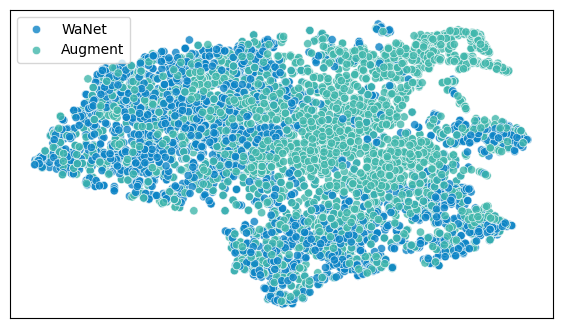

In [54]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/stl10/clean_encoder/model_1000.pth',
    encoder_usage_info='stl10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
# clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()
# 假定已经定义了model, wanet, train_loader和test_loader

train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne_adaptive(args, clean_model, train_loader, test_loader)

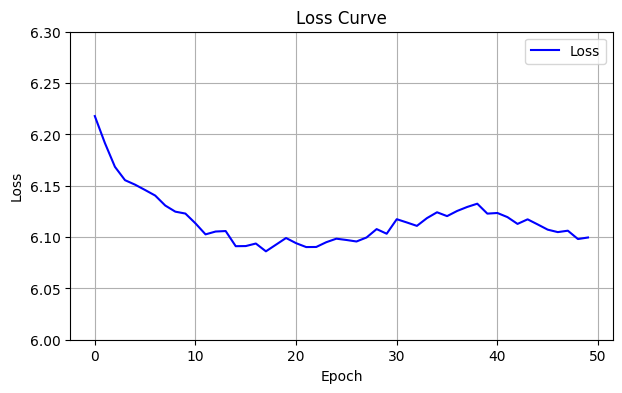

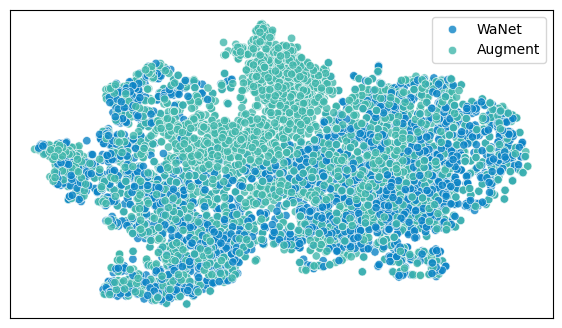

In [44]:
res = pickle.load(open('insight/stl10_res.pkl', 'rb'))
tsne_results = res['tsne']
labels = res['labels']
loss_values = res['loss1']

label_to_str = {0: 'WaNet', 1: 'Augment'}


import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(loss_values, label='Loss', color='blue')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(6, 6.3)  # Setting the y-axis to start from 0 and end at 10
plt.legend()
plt.grid(True)
plt.show()


# 可视化
plt.figure(figsize=(7, 4))
plt.xticks([])
plt.yticks([])
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=[label_to_str[label.item()] for label in labels],
    palette = sns.color_palette(["#0c84c6", "#41b7ac"]),
    legend="full",
    alpha=0.8
)
np.save(f'insight/{args.encoder_usage_info}_array.npy', tsne_results)
plt.savefig(f'{args.encoder_usage_info}.pdf')
# plt.title('t-SNE visualization of model features')
plt.show()

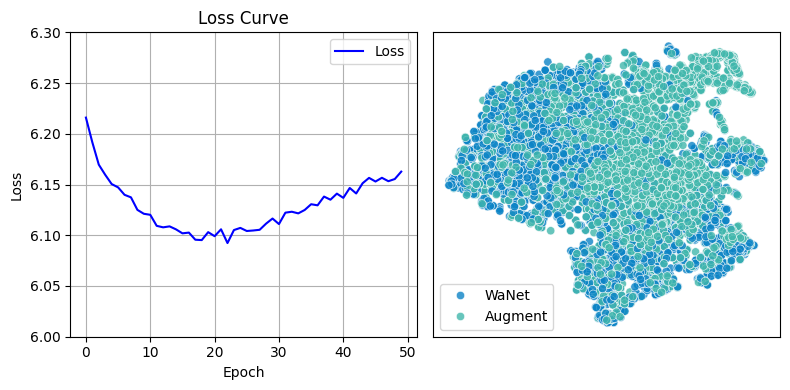

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# 加载数据
res = pickle.load(open('insight/stl10_res.pkl', 'rb'))
tsne_results = res['tsne']
labels = res['labels']
loss_values = res['loss1']

label_to_str = {0: 'WaNet', 1: 'Augment'}

# 创建1行2列的图布局
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# 第一个子图：绘制Loss曲线
axs[0].plot(loss_values, label='Loss', color='blue')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(6, 6.3)  # 设置y轴范围
axs[0].legend()
axs[0].grid(True)

# 第二个子图：绘制t-SNE可视化
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=[label_to_str[label.item()] for label in labels],
    palette=sns.color_palette(["#0c84c6", "#41b7ac"]),
    legend="full",
    alpha=0.8,
    ax=axs[1]
)
axs[1].set_xticks([])  # 移除x轴刻度
axs[1].set_yticks([])  # 移除y轴刻度

# 假设args是一个有encoder_usage_info属性的对象，这里直接用字符串代替
# args_encoder_usage_info = 'example_usage_info'

# 保存t-SNE结果的NumPy数组
# np.save(f'insight/{args_encoder_usage_info}_array.npy', tsne_results)

# 保存整个图为PDF
plt.tight_layout()
plt.savefig(f'insight/insight.pdf')

plt.show()


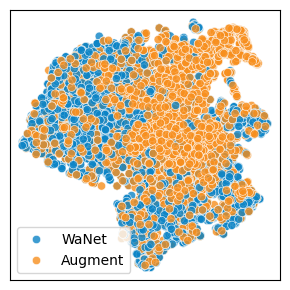

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# 加载数据
res = pickle.load(open('insight/stl10_res.pkl', 'rb'))
tsne_results = res['tsne']
labels = res['labels']
loss_values = res['loss1']

label_to_str = {0: 'WaNet', 1: 'Augment'}

# 创建1行2列的图布局
fig, axs = plt.subplots(1, 1, figsize=(3, 3))


# 第二个子图：绘制t-SNE可视化
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=[label_to_str[label.item()] for label in labels],
    palette=sns.color_palette(["#0c84c6", "#F78F1E"]),
    legend="full",
    alpha=0.8,
    ax=axs
)
axs.set_xticks([])  # 移除x轴刻度
axs.set_yticks([])  # 移除y轴刻度

# 假设args是一个有encoder_usage_info属性的对象，这里直接用字符串代替
# args_encoder_usage_info = 'example_usage_info'

# 保存t-SNE结果的NumPy数组
# np.save(f'insight/{args_encoder_usage_info}_array.npy', tsne_results)

# 保存整个图为PDF
plt.tight_layout()
plt.savefig(f'insight/insight.pdf')

plt.show()
